In [1]:
%pylab inline
import pandas
import numpy
import ggplot
df = pandas.read_csv('improved-dataset/turnstile_weather_v2.csv')

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Preprocessing:

#1 Split data set on rain vs. not rain, and extract the column of interest ENTRIESn_hourly
rain = df[df.rain == 1]['ENTRIESn_hourly']
not_rain = df[df.rain == 0]['ENTRIESn_hourly']
#2 Descriptive Statistics
print "Rain: ",round(np.mean(rain),2), np.median(rain), len(rain)
print "Not Rain: ",round(np.mean(not_rain),2),np.median(not_rain), len(not_rain)
print 
print rain.describe() > not_rain.describe()

#The mean entries during rain are quite a bit higher, but the standard deviation is higher as well. 
#At each quartile (25/50-median/75), ENTRIESn_hourly are higher in the the rain versus no rain. The effect of outliers
#influences the mean/std, but has less influence over quartiles (including the median). So, we see that the median 
#ENTRIESn_hourly is higher during rain.


Rain:  2028.2 939.0 9585
Not Rain:  1845.54 893.0 33064

count    False
mean      True
std       True
min      False
25%       True
50%       True
75%       True
max      False
Name: ENTRIESn_hourly, dtype: bool


In [3]:
#Section 1. Statistical Test Code

from scipy.stats import ttest_ind,shapiro,mannwhitneyu

#Shapiro test for normality - Neither sample is normal
#H0 - samples are normal
#HA - samples are not normal
#In both cases, reject null hypothesis: both p-values <.001
s1,s_p1 = shapiro(rain)
s2,s_p2 = shapiro(not_rain)

#Mann Whitney U test to see whether the samples come from the same distribution
#H0 - samples are from the same distribution
#HA - samples are not from the same distribution
#Reject null hypothesis: p-value <.001
U,u_p = mannwhitneyu(rain,not_rain)


print s1,s_p1
print s2,s_p2
print U, u_p


0.593882083893 0.0
0.595618069172 0.0
153635120.5 2.74106957124e-06


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/stats/morestats.py:624: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


###Section 1. Statistical Test Responses

Which statistical test did you use to analyze the NYC subway data? Did you use a one-tail or a two-tail P value? What is the null hypothesis? What is your p-critical value?

- I used the Mann Whitney U Test To Analyze the NYC Subway data.
- Tails: 2 tails
- Null Hypothesis: The two samples are the same. P(X>Y)=0.5 - The probability of choosing a value
- P-Critical Value: alpha = .01 

Why is this statistical test applicable to the dataset? In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.

- The Mann Whitney U test is a non-parametric test that is applicable to the dataset because the distributions of ridership under the rain/no-rain conditions follow a non-normal distribution.
- To statistically validate the conclusion above, i ran a shapiro wilks test on each of the two conditions: rain/not-rain, and received p-values < .001 for both data sets, thereby rejecting the null hyothesis that each sample is drawn from a normal distribution
- Therefore, the Mann Whitney U test is applicable to our dataset because it does not assume that our data is drawn from any particular underlying distribution.

What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.

- Results from this test: 
- U statistic  = 153635120.5, p value = 2.74106957124e-06, 
- rain_mean ~= 2028, not_rain_mean ~= 1845
- rain_median ~= 939, not_rain_median ~= 893

What is the significance and interpretation of these results?

- The descriptive statistics (mean, median) supplement our underlying belief that ridership is higher during rain, but, the Mann-Whitney U test doesnt make a statement about this. However, given the p-value <.0001, it says that probability that the two samples are the same given this data is very very low. So, we can reject this null hypothesis at the alpha = .01 level. These samples are not the same, and combined with our descriptive statistics, we know that the mean/median for the rain data are higher than that of the not_rain data.

In [71]:
df.head(100)

,UNIT,DATEn,TIMEn,ENTRIESn,EXITSn,ENTRIESn_hourly,EXITSn_hourly,datetime,hour,day_week,...,pressurei,rain,tempi,wspdi,meanprecipi,meanpressurei,meantempi,meanwspdi,weather_lat,weather_lon
0,R003,05-01-11,00:00:00,4388333,2911002,0,0,2011-05-01 00:00:00,0,6,...,30.22,0,55.9,3.5,0.000000,30.258000,55.980000,7.860000,40.700348,-73.887177
1,R003,05-01-11,04:00:00,4388333,2911002,0,0,2011-05-01 04:00:00,4,6,...,30.25,0,52.0,3.5,0.000000,30.258000,55.980000,7.860000,40.700348,-73.887177
2,R003,05-01-11,12:00:00,4388333,2911002,0,0,2011-05-01 12:00:00,12,6,...,30.28,0,62.1,6.9,0.000000,30.258000,55.980000,7.860000,40.700348,-73.887177
3,R003,05-01-11,16:00:00,4388333,2911002,0,0,2011-05-01 16:00:00,16,6,...,30.26,0,57.9,15.0,0.000000,30.258000,55.980000,7.860000,40.700348,-73.887177
4,R003,05-01-11,20:00:00,4388333,2911002,0,0,2011-05-01 20:00:00,20,6,...,30.28,0,52.0,10.4,0.000000,30.258000,55.980000,7.860000,40.700348,-73.887177
5,R003,05-02-11,00:00:00,4388348,2911036,15,34,2011-05-02 00:00:00,0,0,...,30.31,0,50.0,6.9,0.000000,30.238333,54.166667,8.250000,40.700348,-73.887177
6,R003,05-02-11,04:00:00,5818689,3874767,19,40,2011-05-02 04:00:00,4,0,...,30.27,0,50.0,4.6,0.000000,30.238333,54.166667,8.250000,40.700348,-73.887177
7,R003,05-02-11,08:00:00,4388855,2911194,488,118,2011-05-02 08:00:00,8,0,...,30.30,0,53.1,10.4,0.000000,30.238333,54.166667,8.250000,40.700348,-73.887177
8,R003,05-02-11,12:00:00,4389345,2911326,490,132,2011-05-02 12:00:00,12,0,...,30.24,0,57.0,11.5,0.000000,30.238333,54.166667,8.250000,40.700348,-73.887177
9,R003,05-02-11,16:00:00,4389576,2911558,231,232,2011-05-02 16:00:00,16,0,...,30.16,0,59.0,11.5,0.000000,30.238333,54.166667,8.250000,40.700348,-73.887177


In [72]:
df..hist()
log(df.ENTRIESn_hourly + 1).hist()

SyntaxError: invalid syntax (<ipython-input-72-3d41f3facf67>, line 1)

In [73]:
#2: Prediction
import numpy as np
import pandas
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score
from numpy import correlate

def normalize_features(features):
    ''' 
    Returns the means and standard deviations of the given features, along with a normalized feature
    matrix.
    ''' 
    means = np.mean(features, axis=0)
    std_devs = np.std(features, axis=0)
    normalized_features = (features - means) / std_devs
    return means, std_devs, normalized_features

def recover_params(means, std_devs, norm_intercept, norm_params):
    ''' 
    Recovers the weights for a linear model given parameters that were fitted using
    normalized features. Takes the means and standard deviations of the original
    features, along with the intercept and parameters computed using the normalized
    features, and returns the intercept and parameters that correspond to the original
    features.
    ''' 
    intercept = norm_intercept - np.sum(means * norm_params / std_devs)
    params = norm_params / std_devs
    return intercept, params

def linear_regression_2(features, values):
    """
    Perform linear regression given a data set with an arbitrary number of features.
    """
    
    clf = SGDRegressor(n_iter = 200)
    clf.fit(features, values)
    intercept = clf.intercept_
    params = clf.coef_
    return intercept, params

def predictions(dataframe):
    features = dataframe[['tempi','pressurei','precipi','wspdi']]#, 'precipi', 'fog','pressurei','tempi','wspdi'
    dummy_units = pandas.get_dummies(dataframe[['UNIT','hour','rain','weekday','fog']], prefix='unit')#,'weekday','hour'
    features = features.join(dummy_units)
    
    # Values
    values = log(dataframe['ENTRIESn_hourly']+1)
    
    # Get numpy arrays
    features_array = features.values
    values_array = values.values
    
    means, std_devs, normalized_features_array = normalize_features(features_array)

    # Perform gradient descent
    norm_intercept, norm_params = linear_regression_2(normalized_features_array, values_array)
    
    intercept, params = recover_params(means, std_devs, norm_intercept, norm_params)
    
    #predictions = intercept + np.dot(features_array, params)
    # The following line would be equivalent:
    predictions = norm_intercept + np.dot(normalized_features_array, norm_params)
    r_2 = r2_score(values,predictions)
    
    return predictions,intercept, params, r_2



In [74]:
preds,intercept, params, r_2 = predictions(df)
print r_2

0.433829843034


###Section 2. Linear Regression

What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model:

- **Gradient descent using Scikit Learn**

What features (input variables) did you use in your model? Did you use any dummy variables as part of your features?

- Fog,
- Dummy Variables: UNIT

Why did you select these features in your model? [Provide intuition or evidence]

-


What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model?

- Coefficients: 

What is your model’s R2 (coefficients of determination) value?

- R2 = 

What does this R2 value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R2  value?

- __ % of the variation in the dependent variable is explained by the independent variables (predictors).
- This linear model is  ____ for this dataset, given this R2 value because ...

In [76]:
df.corr()

,ENTRIESn,EXITSn,ENTRIESn_hourly,EXITSn_hourly,hour,day_week,weekday,latitude,longitude,fog,...,pressurei,rain,tempi,wspdi,meanprecipi,meanpressurei,meantempi,meanwspdi,weather_lat,weather_lon
ENTRIESn,1.000000,0.924739,0.585895,0.530925,-0.005358,-0.001476,-0.002457,0.126110,-0.207909,-0.010882,...,-0.003690,-0.002044,0.013471,-0.091524,0.027374,0.007444,0.015420,-0.122455,0.085958,-0.224917
EXITSn,0.924739,1.000000,0.552648,0.582130,-0.005421,-0.002259,-0.002270,0.072566,-0.237180,-0.010703,...,-0.002794,-0.003339,0.015093,-0.107243,0.032721,0.008660,0.017962,-0.144446,0.023488,-0.255539
ENTRIESn_hourly,0.585895,0.552648,1.000000,0.640267,0.286798,-0.094897,0.145431,0.115635,-0.124047,-0.008590,...,-0.033361,0.025825,0.089596,0.056030,0.035649,-0.006186,-0.026693,-0.039724,0.089156,-0.137889
EXITSn_hourly,0.530925,0.582130,0.640267,1.000000,0.252758,-0.080410,0.125729,0.091075,-0.134714,-0.009003,...,-0.031422,0.024134,0.090438,0.038179,0.037047,-0.005257,-0.021891,-0.055954,0.059765,-0.152295
hour,-0.005358,-0.005421,0.286798,0.252758,1.000000,0.006010,-0.005271,-0.000904,0.001106,0.038454,...,-0.067935,-0.000697,0.274048,0.255057,-0.001771,-0.002360,0.001370,0.000496,-0.000731,0.001431
day_week,-0.001476,-0.002259,-0.094897,-0.080410,0.006010,1.000000,-0.805805,-0.000328,-0.001881,0.016179,...,-0.061134,-0.082490,-0.029176,-0.223378,-0.127240,-0.064296,-0.035553,-0.316833,-0.001059,-0.002209
weekday,-0.002457,-0.002270,0.145431,0.125729,-0.005271,-0.805805,1.000000,-0.000396,0.002103,-0.008605,...,0.042391,0.130846,-0.011989,0.155019,0.112940,0.044583,-0.014609,0.219874,0.000124,0.002869
latitude,0.126110,0.072566,0.115635,0.091075,-0.000904,-0.000328,-0.000396,1.000000,0.129291,-0.016329,...,-0.012792,0.003906,-0.008954,0.099332,-0.043688,-0.013454,-0.010911,0.140890,0.973716,0.054721
longitude,-0.207909,-0.237180,-0.124047,-0.134714,0.001106,-0.001881,0.002103,0.129291,1.000000,0.017415,...,-0.002685,0.000133,-0.049732,0.354106,-0.098675,-0.002824,-0.060602,0.502253,0.167971,0.953024
fog,-0.010882,-0.010703,-0.008590,-0.009003,0.038454,0.016179,-0.008605,-0.016329,0.017415,1.000000,...,-0.084171,0.144566,-0.036755,-0.015084,0.091856,-0.091208,-0.031044,0.050557,-0.014650,0.018134


###Section 3. Visualization

Please include two visualizations that show the relationships between two or more variables in the NYC subway data.
Remember to add appropriate titles and axes labels to your plots. Also, please add a short description below each figure commenting on the key insights depicted in the figure.

3.1 One visualization should contain two histograms: one of  ENTRIESn_hourly for rainy days and one of ENTRIESn_hourly for non-rainy days.
You can combine the two histograms in a single plot or you can use two separate plots.
If you decide to use to two separate plots for the two histograms, please ensure that the x-axis limits for both of the plots are identical. It is much easier to compare the two in that case.
For the histograms, you should have intervals representing the volume of ridership (value of ENTRIESn_hourly) on the x-axis and the frequency of occurrence on the y-axis. For example, each interval (along the x-axis), the height of the bar for this interval will represent the number of records (rows in our data) that have ENTRIESn_hourly that falls in this interval.
Remember to increase the number of bins in the histogram (by having larger number of bars). The default bin width is not sufficient to capture the variability in the two samples.

3.2 One visualization can be more freeform. You should feel free to implement something that we discussed in class (e.g., scatter plots, line plots) or attempt to implement something more advanced if you'd like. Some suggestions are:
Ridership by time-of-day
Ridership by day-of-week

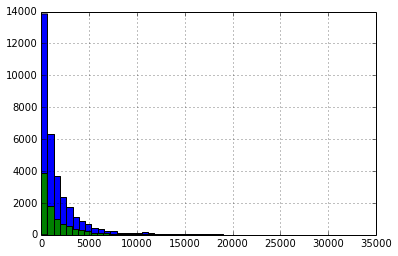

In [77]:
#3.1
df[df.rain==0].ENTRIESn_hourly.hist(bins=50)
df[df.rain==1].ENTRIESn_hourly.hist(bins=50)

#3.2

###Section 4. Conclusion

Please address the following questions in detail. Your answers should be 1-2 paragraphs long.
4.1 From your analysis and interpretation of the data, do more people ride
the NYC subway when it is raining or when it is not raining?  
4.2 What analyses lead you to this conclusion? You should use results from both your statistical
tests and your linear regression to support your analysis.


###Section 5. Reflection

Please address the following questions in detail. Your answers should be 1-2 paragraphs long.
5.1 Please discuss potential shortcomings of the methods of your analysis, including:
Dataset,
Analysis, such as the linear regression model or statistical test.
5.2 (Optional) Do you have any other insight about the dataset that you would like to share with us?


In [ ]:
# QQ plot on residuals
# EOF Score
# Somers d
# vif - inflation parameter
# 